In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10587002503888254202, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 14631175355626765536
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 2620385206686001290
 physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1", name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 13665531176632257257
 physical_device_desc: "device: 2, name: GeForce GTX 1080 Ti, pci bus id: 0000:87:00.0, compute capability: 6.1", name: "/device:GPU:3"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 189309482989981159
 physical_devi

In [33]:
import os
import numpy as np
np.random.seed(777)

import keras.backend as K
from keras.preprocessing.image import  ImageDataGenerator
from keras.applications.nasnet import NASNetLarge, preprocess_input
from keras.applications.vgg19 import VGG19

from keras.models import Model,load_model
from keras import Input
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2

from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D, concatenate

import matplotlib.pyplot as plt
%matplotlib inline
# import keras.backend as K
# from keras.utils import plot_model

In [13]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.4.0
dim_ordering: tf


In [14]:
output_classes = 2
batch_size = 8
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = 59168
nb_validation_samples = 18384
nb_test_samples = 967

In [15]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test'

In [16]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59168 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [17]:
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
rmsp_opt = RMSprop(lr=1e-4, decay=0.9)

In [18]:
# for i, layer in enumerate(NasNetLarge_model.layers):
#     print(i, layer.name)

In [23]:
def vgg19_model():
    base_model = VGG19(weights='imagenet', include_top=False, pooling='avg')
    x = base_model.output
    # x = GlobalAveragePooling2D()(x)
    x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    prediction = Dense(output_classes, activation=tf.nn.softmax)(x)

    vgg19_model = Model(inputs=base_model.input,outputs=prediction)
    
    vgg19_model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
    return vgg19_model

In [24]:
def NASNetLarge_model():
    base_model = NASNetLarge(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    prediction = Dense(output_classes, activation=tf.nn.softmax)(x)
    NASNetLarge_model = Model(inputs=base_model.input,outputs=prediction)
    
    NASNetLarge_model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
    return NASNetLarge_model

In [25]:
NASNetLarge_model= NASNetLarge_model()
vgg19_model= vgg19_model()

In [27]:
img = Input(shape=(224, 224,3),name='img')

feature1=NASNetLarge_model(img)
feature2=vgg19_model(img)

for layer in NASNetLarge_model.layers[:300]:  
    layer.trainable = False 
for layer in NASNetLarge_model.layers[300:]:  
    layer.trainable = True  

for layer in vgg19_model.layers[:170]:  
    layer.trainable = False 
for layer in vgg19_model.layers[170:]:  
    layer.trainable = True  

x = concatenate([feature1,feature2])

x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(2, activation=tf.nn.softmax, name='output')(x)

model=Model(inputs=img,outputs=output)

In [28]:
model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

# with open('ensemble_history.txt','w') as f:
#     f.write(str(history.history))

Epoch 1/50
7396/7396 [==============================] - 3290s 445ms/step - loss: 0.7556 - acc: 0.7225 - val_loss: 0.7984 - val_acc: 0.6812
Epoch 2/50
7396/7396 [==============================] - 3284s 444ms/step - loss: 0.6865 - acc: 0.7703 - val_loss: 0.8128 - val_acc: 0.6827
Epoch 3/50
7396/7396 [==============================] - 3061s 414ms/step - loss: 0.6541 - acc: 0.7887 - val_loss: 0.8109 - val_acc: 0.6837
Epoch 4/50
7396/7396 [==============================] - 3066s 415ms/step - loss: 0.6266 - acc: 0.8020 - val_loss: 0.8113 - val_acc: 0.6878
Epoch 5/50
7396/7396 [==============================] - 3088s 417ms/step - loss: 0.6037 - acc: 0.8085 - val_loss: 0.8130 - val_acc: 0.6830
Epoch 6/50
7396/7396 [==============================] - 3084s 417ms/step - loss: 0.5860 - acc: 0.8156 - val_loss: 0.8179 - val_acc: 0.6864
Epoch 7/50
7396/7396 [==============================] - 3072s 415ms/step - loss: 0.5736 - acc: 0.8189 - val_loss: 0.7643 - val_acc: 0.7034
Epoch 8/50
7396/7396 [=====

In [29]:
model.save('models/21.Ensemble5-ISBI19-Model.h5')
model.save_weights('models/21.Ensemble5-ISBI19-Weights.h5')

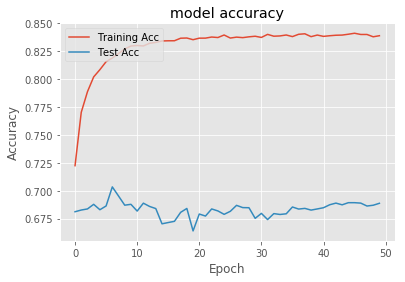

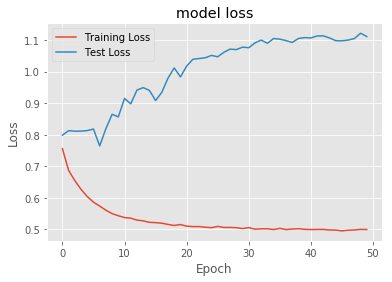

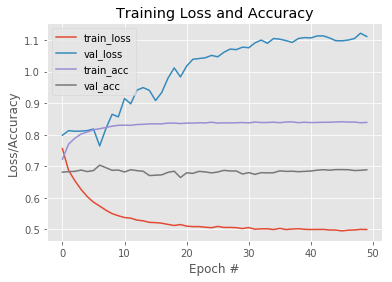

In [34]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [31]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  1.130405188202858
Validation Accuracy:  0.6825


In [35]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))


121/120 [==============================] - 24s 200ms/step
No of errors = 310/967


Confusion Matrix
[[625  30]
 [280  32]]


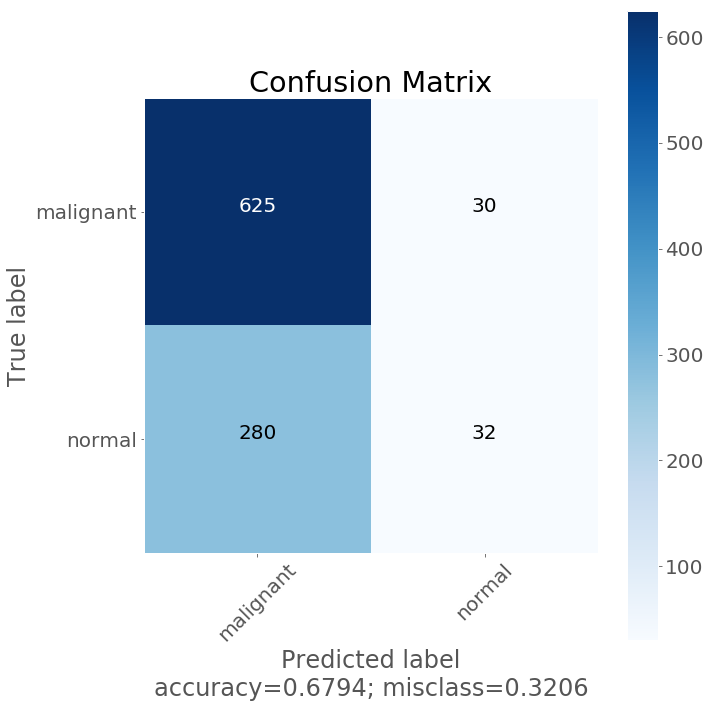

In [36]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/17.Ensemble-Models1-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,title='Confusion Matrix')

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[625  30]
 [280  32]]
              precision    recall  f1-score   support

   malignant       0.69      0.95      0.80       655
      normal       0.52      0.10      0.17       312

   micro avg       0.68      0.68      0.68       967
   macro avg       0.60      0.53      0.49       967
weighted avg       0.63      0.68      0.60       967



In [38]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  67.94208893485005
Sensitivity :  69.06077348066299
Specificity :  51.61290322580645


In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc*100))
print('Precision: {:.4f}'.format(prec*100))
print('Recall:    {:.4f}'.format(recall*100))
print('F1:        {:.4f}'.format(f1*100))

Accuracy:  67.9421
Precision: 51.6129
Recall:    10.2564
F1:        17.1123


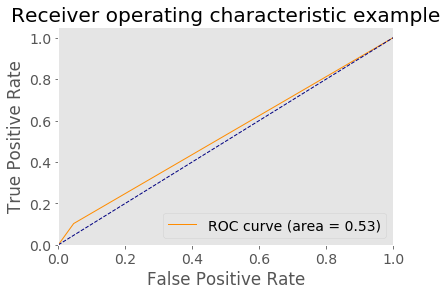

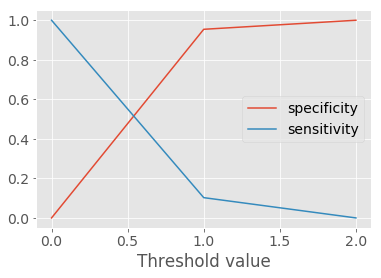

In [40]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()